### Import Libraries

In [1]:
# Pandas, Numpy, MatPlotlib, Seaborn, Coubter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.feature_selection import RFE, SelectKBest, chi2, SelectPercentile, f_classif

# Train Test Split & CV
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, GridSearchCV

# Model

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, plot_confusion_matrix, plot_roc_curve, roc_curve, matthews_corrcoef,plot_precision_recall_curve,precision_recall_curve

# Joblib
import joblib 

# Others
global str


In [2]:
data = pd.read_csv('./static/modeling.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)
data.head()

,open_flag,age,domain,country,day,character_length,last_time_open_email,last_time_open_shopee,last_time_checkout_shopee,open_frequency,login_frequency,checkout_frequency
0,0,47.0,@gmail.com,Philippines,Tuesday,ideal,0-1 year,0-1 year,0-1 year,0.044444,1.427778,0.111111
1,1,25.0,other,Philippines,Tuesday,ideal,0-1 year,0-1 year,0-1 year,0.261111,1.633333,0.066667
2,0,NaN,@yahoo.com,Thailand,Tuesday,ideal,0-1 year,0-1 year,0-1 year,0.111111,2.227778,0.527778
3,0,24.0,@yahoo.com,Singapore,Tuesday,ideal,0-1 year,0-1 year,0-1 year,0.005556,0.938889,0.100000
4,0,NaN,other,Thailand,Tuesday,ideal,0-1 year,0-1 year,0-1 year,0.000000,0.150000,0.000000


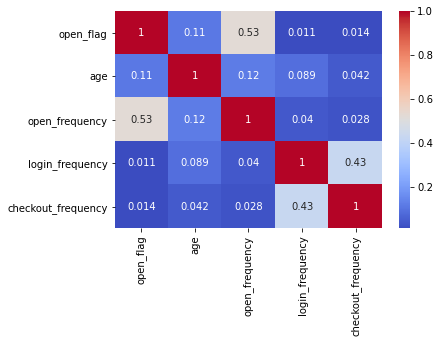

In [3]:
sns.heatmap(data.corr(),annot=True,cmap='coolwarm')
plt.show()

## Data Splitting

In [4]:
X = data.drop('open_flag', axis=1)
y = data['open_flag']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, stratify=y,random_state=2021)

### Preprocess
1. Simple Imputer --> Age (median)
1. One Hot --> Character Length,hari,country,domain
1. Ordinal --> last_time_open_email, last_time_open_shopee, last_time_checkout_shopee
1. Robust --> open_frequency, login_frequency, checkout_frequency

In [5]:
ordinal_mapping = [
    {'col' : 'last_time_open_email',
    'mapping':{None:0, '0-1 year':1,'1-2 years':2,'2-3 years':3,'more than 3 years':4}},
    {'col' : 'last_time_open_shopee',
    'mapping':{None:0, '0-1 year':1,'1-2 years':2,'2-3 years':3,'more than 3 years':4}},
    {'col' : 'last_time_checkout_shopee',
    'mapping':{None:0, '0-1 year':1,'1-2 years':2,'2-3 years':3,'more than 3 years':4}}
]

ordinal_encoder = ce.OrdinalEncoder(cols=['last_time_open_email','last_time_open_shopee','last_time_checkout_shopee'],mapping=ordinal_mapping)

In [6]:
transformer = ColumnTransformer([
    ('age_impute',SimpleImputer(strategy='median'),['age']),
    ('onehotpipe',OneHotEncoder(drop='first'),['character_length','day','domain','country']),
    ('ordinarypipe',ordinal_encoder,['last_time_open_email','last_time_open_shopee','last_time_checkout_shopee']),
    ('robust', RobustScaler(), ['open_frequency','login_frequency','checkout_frequency'])
],remainder='passthrough')

### Model Used :
1. Decision Tree Classifier
1. Logistic Regression
1. Naive Bayes

In [7]:
dtc = DecisionTreeClassifier(random_state=2021)
logreg = LogisticRegression(random_state=2021)
nb = GaussianNB()
smote=SMOTE(random_state=2021)

## Pipeline Benchmark



In [8]:
#1. Decision Tree
pipeline_dtc = Pipeline([
    ('transformer',transformer),
    ('rfe', RFE(dtc)),
    ('resampling', smote),
    ('clf', dtc)
])

#2. Logistic Regression
pipeline_logreg = Pipeline([
    ('transformer',transformer),
    ('rfe', RFE(logreg)),
    ('resampling', smote),
    ('clf', logreg)
])


#3. Gauss Naive Bayes
pipeline_nb = Pipeline([
    ('transformer',transformer),
    ('selection',SelectPercentile(f_classif)),
    ('resampling',smote),
    ('clf',nb)
])

## Metrics Used --> Recall. Because :
<img src='./interface/metrics used.png'>

In [9]:
rskf = RepeatedStratifiedKFold(n_splits=5, random_state=2021)

dtc_score = cross_val_score(pipeline_dtc, X_train_val, y_train_val, scoring='recall', cv=rskf, n_jobs=-1, verbose=1)
logreg_score = cross_val_score(pipeline_logreg, X_train_val, y_train_val, scoring='recall', cv=rskf, n_jobs=-1, verbose=1)
nb_score = cross_val_score(pipeline_nb, X_train_val, y_train_val, scoring='recall', cv=rskf, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.5s finished


In [10]:
print('DTC Val Score:', dtc_score)
print('Logreg Val Score:', logreg_score)
print('Naive Bayes Val Score:', nb_score)

DTC Val Score: [0.48791209 0.46648352 0.48325096 0.47472527 0.46208791 0.46978022
 0.43461538 0.45249863 0.4532967  0.47802198 0.45604396 0.46978022
 0.46512905 0.46428571 0.46813187 0.47527473 0.44505495 0.47611203
 0.46648352 0.47637363 0.43956044 0.47967033 0.45249863 0.47802198
 0.48131868 0.47802198 0.45769231 0.44975288 0.42527473 0.46813187
 0.46923077 0.47527473 0.45414607 0.48351648 0.46813187 0.47582418
 0.47252747 0.45689182 0.4478022  0.47692308 0.49010989 0.45
 0.48325096 0.47142857 0.45549451 0.45384615 0.45714286 0.47830862
 0.46263736 0.47197802]
Logreg Val Score: [0.72252747 0.72032967 0.71773751 0.72527473 0.73681319 0.72142857
 0.71153846 0.73695772 0.71648352 0.74340659 0.74120879 0.71813187
 0.72267985 0.71373626 0.72197802 0.72417582 0.72197802 0.71169687
 0.72967033 0.73186813 0.70824176 0.72362637 0.73860516 0.71648352
 0.73296703 0.73351648 0.73351648 0.71499176 0.71428571 0.72362637
 0.71813187 0.74450549 0.71828666 0.72032967 0.73351648 0.72912088
 0.72032967

In [11]:
print('DTC Val Score:', dtc_score.mean())
print('Logreg Val Score:', logreg_score.mean())
print('Naive Bayes Val Score:', nb_score.mean())

DTC Val Score: 0.46579503472913686
Logreg Val Score: 0.7245685742044887
Naive Bayes Val Score: 0.6303591131548297


## Try to Tuning Logistic Regression & Gaussian Naive Bayes

### 1. Tuning Logistic Regression

In [12]:
pipeline_logreg.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('age_impute', SimpleImputer(strategy='median'),
                                    ['age']),
                                   ('onehotpipe', OneHotEncoder(drop='first'),
                                    ['character_length', 'day', 'domain',
                                     'country']),
                                   ('ordinarypipe',
                                    OrdinalEncoder(cols=['last_time_open_email',
                                                         'last_time_open_shopee',
                                                         'last_time_checkout_shopee'],
                                                   mapping=[{'col': 'last_time_open_emai...
                                                             'mapping': {None: 0,
                                                                         '0-1 year': 1,
             

In [13]:
hyperparam_space_logreg = {
    'clf__max_iter':[100, 200, 300],
    'rfe__n_features_to_select':[8,12,16,20],
    'clf__solver': ['lbfgs', 'liblinear', 'newton-cg']
}

skf = StratifiedKFold(n_splits=5)

gridsearch_logreg = GridSearchCV(pipeline_logreg, hyperparam_space_logreg, scoring='recall', n_jobs=-1, cv=skf,verbose=1)
gridsearch_logreg.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.4min finished
C:\Users\johan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\johan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('age_impute',
                                                                         SimpleImputer(strategy='median'),
                                                                         ['age']),
                                                                        ('onehotpipe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['character_length',
                                                                          'day',
                                                                          'domain',
                                                          

In [14]:
gridsearch_logreg.best_params_

{'clf__max_iter': 100, 'clf__solver': 'lbfgs', 'rfe__n_features_to_select': 16}

In [15]:
gridsearch_logreg.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age_impute',
                                                  SimpleImputer(strategy='median'),
                                                  ['age']),
                                                 ('onehotpipe',
                                                  OneHotEncoder(drop='first'),
                                                  ['character_length', 'day',
                                                   'domain', 'country']),
                                                 ('ordinarypipe',
                                                  OrdinalEncoder(cols=['last_time_open_email',
                                                                       'last_time_open_shopee',
                                                                       'last_time_checkout_shopee'],
                                               

### 1A. Logistic Regression Benchmark

In [16]:
logreg = pipeline_logreg.fit(X_train_val, y_train_val)
y_pred_logreg = logreg.predict(X_test) 
print(classification_report(y_test, y_pred_logreg))

C:\Users\johan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\johan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

              precision    recall  f1-score   support

           0       0.94      0.84      0.89     12372
           1       0.46      0.73      0.56      2276

    accuracy                           0.82     14648
   macro avg       0.70      0.79      0.73     14648
weighted avg       0.87      0.82      0.84     14648



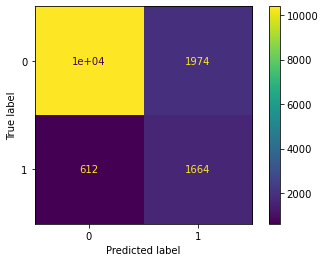

In [17]:
plot_confusion_matrix(logreg, X_test, y_test)
plt.show()

### 1B. Logistic Regression Tuned

In [18]:
logreg_tuned = gridsearch_logreg.best_estimator_.fit(X_train_val, y_train_val)
y_pred_logreg_tuned = logreg_tuned.predict(X_test)
print(classification_report(y_test, y_pred_logreg_tuned))

C:\Users\johan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\johan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

              precision    recall  f1-score   support

           0       0.94      0.84      0.89     12372
           1       0.45      0.73      0.56      2276

    accuracy                           0.82     14648
   macro avg       0.70      0.79      0.73     14648
weighted avg       0.87      0.82      0.84     14648



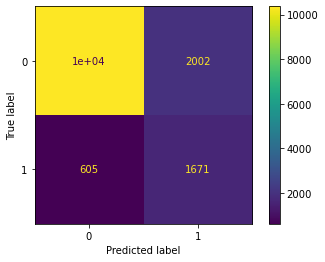

In [19]:
plot_confusion_matrix(logreg_tuned, X_test, y_test)
plt.show()

In [20]:
print(recall_score(y_test,y_pred_logreg))
print(recall_score(y_test,y_pred_logreg_tuned))

0.7311072056239016
0.734182776801406


### 2. Tuning Gaussian Naive Bayes

In [21]:
pipeline_nb.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('age_impute', SimpleImputer(strategy='median'),
                                    ['age']),
                                   ('onehotpipe', OneHotEncoder(drop='first'),
                                    ['character_length', 'day', 'domain',
                                     'country']),
                                   ('ordinarypipe',
                                    OrdinalEncoder(cols=['last_time_open_email',
                                                         'last_time_open_shopee',
                                                         'last_time_checkout_shopee'],
                                                   mapping=[{'col': 'last_time_open_emai...
                                                             'mapping': {None: 0,
                                                                         '0-1 year': 1,
             

In [22]:
hyperparam_space_nb = {
    'selection__percentile':[1,5,10,30,50,100],
    'resampling__k_neighbors':[1,5,10,30,50],
    'clf__var_smoothing':[1e-9]
#     'clf__priors':[(0.2,0.8)]
    
}

skf = StratifiedKFold(n_splits=5)

gridsearch_nb = GridSearchCV(pipeline_nb, hyperparam_space_nb, scoring='recall', n_jobs=-1, cv=skf,verbose=1)
gridsearch_nb.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   14.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('age_impute',
                                                                         SimpleImputer(strategy='median'),
                                                                         ['age']),
                                                                        ('onehotpipe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['character_length',
                                                                          'day',
                                                                          'domain',
                                                          

In [23]:
gridsearch_nb.best_params_

{'clf__var_smoothing': 1e-09,
 'resampling__k_neighbors': 50,
 'selection__percentile': 50}

In [24]:
report_grid = pd.DataFrame(gridsearch_nb.cv_results_).sort_values('rank_test_score', ascending=True)
# report_grid.head(2)

In [25]:
gridsearch_nb.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age_impute',
                                                  SimpleImputer(strategy='median'),
                                                  ['age']),
                                                 ('onehotpipe',
                                                  OneHotEncoder(drop='first'),
                                                  ['character_length', 'day',
                                                   'domain', 'country']),
                                                 ('ordinarypipe',
                                                  OrdinalEncoder(cols=['last_time_open_email',
                                                                       'last_time_open_shopee',
                                                                       'last_time_checkout_shopee'],
                                               

## 2A. Gaussian Naive Bayes Benchmark

In [26]:
nb = pipeline_nb.fit(X_train_val, y_train_val)
y_pred_nb = nb.predict(X_test) 
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     12372
           1       0.47      0.65      0.55      2276

    accuracy                           0.83     14648
   macro avg       0.70      0.76      0.72     14648
weighted avg       0.86      0.83      0.84     14648



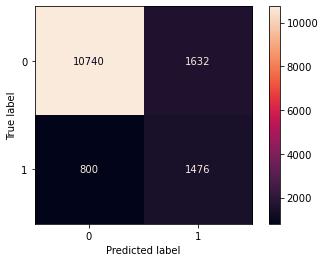

In [27]:
plot_confusion_matrix(nb, X_test, y_test,cmap='rocket')
plt.show()

## 2B. Gaussian Naive Bayes Tuned

In [28]:
nb_tuned = gridsearch_nb.best_estimator_.fit(X_train_val, y_train_val)
y_pred_nb_tuned = nb_tuned.predict(X_test)
y_pred_nb_tuned_proba = (nb_tuned.predict_proba(X_test)[:,1] >= 0.4)
print(classification_report(y_test, y_pred_nb_tuned))

              precision    recall  f1-score   support

           0       0.94      0.73      0.82     12372
           1       0.34      0.76      0.47      2276

    accuracy                           0.73     14648
   macro avg       0.64      0.74      0.65     14648
weighted avg       0.85      0.73      0.77     14648



In [29]:
print(recall_score(y_test, y_pred_nb))
print(recall_score(y_test, y_pred_nb_tuned))

0.648506151142355
0.7561511423550088


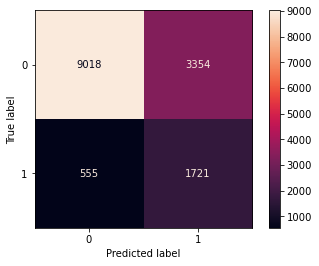

In [30]:
plot_confusion_matrix(nb_tuned, X_test, y_test,cmap='rocket')
plt.show()

## Result

In [31]:
hasil = pd.DataFrame({
    'Decision Tree Classifier':[dtc_score.mean(),'-'],
    'Logistic Regression':[logreg_score.mean(),recall_score(y_test,y_pred_logreg_tuned)],
    'Gaussian Naive Bayes':[recall_score(y_test, y_pred_nb),recall_score(y_test, y_pred_nb_tuned)]
},index=['Benchmark','Tuned'])
hasil

,Decision Tree Classifier,Logistic Regression,Gaussian Naive Bayes
Benchmark,0.465795,0.724569,0.648506
Tuned,-,0.734183,0.756151


### From the result above, we will use model __Gaussian Naive Bayes-Tuned__

## Searching the best threshold from the best model

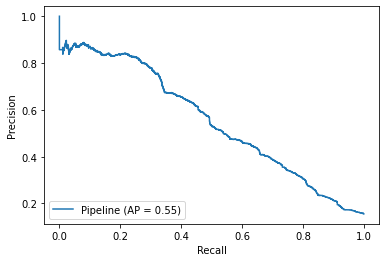

In [32]:
plot_precision_recall_curve(nb_tuned, X_test, y_test)
plt.show()

In [33]:
p, r, t = precision_recall_curve(y_test, nb_tuned.predict_proba(X_test)[:,1])
pr_df = pd.DataFrame({'precision': p[:-1], 'recall': r[:-1], 'threshold': t})
pr_df['jumlah']=pr_df['precision']+pr_df['recall']
# pr_df[(pr_df['recall']>0.83) & (pr_df['precision']>0.26)].head(5)
pr_df[pr_df['threshold']>0.3]

,precision,recall,threshold,jumlah
1982,0.297415,0.808875,0.300144,1.106290
1983,0.297302,0.808436,0.300539,1.105738
1984,0.297398,0.808436,0.300857,1.105834
1985,0.297446,0.808436,0.300938,1.105882
1986,0.297494,0.808436,0.300997,1.105930
...,...,...,...,...
5595,0.857143,0.013181,1.000000,0.870324
5596,0.852941,0.012742,1.000000,0.865683
5597,0.838710,0.011424,1.000000,0.850133
5598,0.866667,0.011424,1.000000,0.878090


## Email Blasting Price
<img src='./interface/Biaya Email.png'>

<a href='https://www.exabytes.co.id/online-marketing/email-marketing'> Blast Email Price</a>

## User Shopee in Indonesia
<img src='./interface/Jumlah User Shopee.png'>

<a href='https://www.sirclo.com/jumlah-pengguna-e-commerce-indonesia-di-tahun-2020-meningkat-pesat/'> User Shopee in Indonesia</a>

## New Customer Cost
<img src='./interface/5x.png'>

<a href = 'https://blog.mokapos.com/2018/02/22/mana-yang-lebih-penting-pelanggan-baru-atau-setia'> New Customer Cost</a>

<img src='interface/metrics used.png'>

1. Dalam kasus ini, kehilangan customer adalah hal yang paling ingin dihindari (FN sekecil mungkin)
1. FP juga diinginkan sekecil mungkin dikarenakan semakin banyak FP berarti semakin banyak email yang terbuang sia - sia
1. FN adalah customer loyal yang seharusnya akan membaca email, namun tidak dikirimin email (berpotensi hilang)
1. FP adalah jumlah customer baru yang diharapkan datang, namun sebenarnya tidak terjadi
1. Menurut artikel diatas, biaya mempertahankan customer lama lebih murah 5x dibanding mencari customer baru
1. Bisa dibilang 5FN = FP
1. Namun, jika dilihat dari biaya mengirim email dan seberapa besar shopee sebagai perusahaan, biaya tambahan per bulan dirasa tidak masalah
1. Oleh karena itu, diambil lah threshold 0.3 dengan model naive bayes benchmark sebagai model terbaik karena memiliki nilai total loss terkecil

In [34]:
def make_confusion_matrix(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    conf_df = pd.DataFrame(
        {'p_0': [tn, fn, tn+fn], 'p_1': [fp, tp, fp+tp]}, index = ['a_0', 'a_1', 'total_prediction']
    )
    conf_df['total_actual'] = conf_df['p_0'] + conf_df['p_1']
    return print(f"Recall Score : {(tp/(fn+tp))*100} %"),print(f"Precision Score : {(tp/(fp+tp))*100} %"), print(f"Accuracy Score : {((tp+tn)/(fp+tp+fn+tn))*100 }%"),print(f"F1 Score : {2*((tp/(fp+tp))*(tp/(fn+tp)))/((tp/(fp+tp))+(tp/(fn+tp)))*100} %")

In [35]:
def threshold(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    conf_df = pd.DataFrame(
        {'p_0': [tn, fn, tn+fn], 'p_1': [fp, tp, fp+tp]}, index = ['a_0', 'a_1', 'total_prediction']
    )
    conf_df['total_actual'] = conf_df['p_0'] + conf_df['p_1']
    User_per_Q3_2019 = 55900000
    Biaya_promosi_email_Per_Satu_Juta_User = 7000000
    Biaya_promosi_email_per_user = Biaya_promosi_email_Per_Satu_Juta_User/1000000
    Biaya_Promosi_Per_Bulan = User_per_Q3_2019 / Biaya_promosi_email_per_user * 1000000
    Biaya_Promosi_Per_Bulan_Actual = ((fp+tp)/(fp+tp+fn+tn))*Biaya_Promosi_Per_Bulan
    return conf_df, print(f'Saved money {round((Biaya_Promosi_Per_Bulan-Biaya_Promosi_Per_Bulan_Actual)/(Biaya_Promosi_Per_Bulan)*100)} %'), print(f"On Target (Read & Sent) = {round(tp/(fp+tp)*100)} %"), print(f'Off Target (Do Not Read but Sent)= {round(fp/(tn+fp)*100)} %'),print(f'Loss due to off target = Rp.{round(fp/(fp+tp+fn+tn)*Biaya_promosi_email_per_user*User_per_Q3_2019):,}',print(f"Loss potential user (Read but Not Sent) = {(fn/(fn+tn)*100)} %")),print(f'On Target/Loss Potential = {(tp/(fp+tp)*100)/(fn/(fn+tn)*100)}'),print({tp/fn})

In [36]:
def thresholdo(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    conf_df = pd.DataFrame(
        {'p_0': [tn, fn, tn+fn], 'p_1': [fp, tp, fp+tp]}, index = ['a_0', 'a_1', 'total_prediction']
    )
    conf_df['total_actual'] = conf_df['p_0'] + conf_df['p_1']
    User_per_Q3_2019 = 55900000
    Biaya_promosi_email_Per_Satu_Juta_User = 7000000
    Biaya_promosi_email_per_user = Biaya_promosi_email_Per_Satu_Juta_User/1000000
    Biaya_Promosi_Per_Bulan = User_per_Q3_2019 / Biaya_promosi_email_per_user * 1000000
    Biaya_Promosi_Per_Bulan_Actual = ((fp+tp)/(fp+tp+fn+tn))*Biaya_Promosi_Per_Bulan
    return print(f'Unecessary Email = {(fp/(tn+fn+fp+tp)*100)}%'),print(f'Loss Potential Customer = {(fn/(tn+fn+fp+tp)*100)}'),print(f'Saved money {(Biaya_Promosi_Per_Bulan-Biaya_Promosi_Per_Bulan_Actual)/(Biaya_Promosi_Per_Bulan)*100} %'),print(f'Total Loss = {(fp+5*fn)/(fn+fp+tn+tp)*100}%')

In [37]:
for i in (np.linspace(0.4,0.6,21)):
    print(f'For Threshold {i} before Tuned:')
    y_pred_thresh = [1 if prob1>i else 0 for prob1 in logreg.predict_proba(X_test)[:,1]]
    thresholdo(confusion_matrix(y_test, y_pred_thresh))
    print('')
    print(f'For Threshold {i} After Tuned:')
    y_pred_thresh = [1 if prob1>i else 0 for prob1 in logreg_tuned.predict_proba(X_test)[:,1]]
    thresholdo(confusion_matrix(y_test, y_pred_thresh))
    print('')

For Threshold 0.4 before Tuned:
Unecessary Email = 21.347624249044237%
Loss Potential Customer = 3.0379574003276897
Saved money 66.15237575095576 %
Total Loss = 36.53741125068269%

For Threshold 0.4 After Tuned:
Unecessary Email = 21.46368104860732%
Loss Potential Customer = 3.0174767886400873
Saved money 66.01583833970508 %
Total Loss = 36.551064991807756%

For Threshold 0.41000000000000003 before Tuned:
Unecessary Email = 20.85608956854178%
Loss Potential Customer = 3.1403604587657017
Saved money 66.74631348989622 %
Total Loss = 36.55789186237029%

For Threshold 0.41000000000000003 After Tuned:
Unecessary Email = 20.80830147460404%
Loss Potential Customer = 3.1335335882031674
Saved money 66.78727471327143 %
Total Loss = 36.47596941561988%

For Threshold 0.42000000000000004 before Tuned:
Unecessary Email = 20.30993992353905%
Loss Potential Customer = 3.2222829055161113
Saved money 67.37438558164938 %
Total Loss = 36.42135445111961%

For Threshold 0.42000000000000004 After Tuned:
Unece

### Comparing the Properties resulted by model :
1. Logistic Regression Benchmark
1. Logistic Regression Tuned
1. Logistic Regression Best Model + Best Threshold
1. Gaussian Naive-Bayes Benchmark
1. Gaussian Naive-Bayes Tuned
1. Gaussian Naive-Bayes Best Model + Best Threshold

### 1. Logistic Regression Benchmark

In [38]:
y_pred_1 = [1 if prob1>0.50 else 0 for prob1 in logreg.predict_proba(X_test)[:,1]]
print('Evaluation Score :')
thresholdo(confusion_matrix(y_test, y_pred_1))
print('')
print('Metrics Score :')
print(make_confusion_matrix(confusion_matrix(y_test, y_pred_1)))

Evaluation Score :
Unecessary Email = 13.476242490442381%
Loss Potential Customer = 4.17804478427089
Saved money 75.16384489350082 %
Total Loss = 34.36646641179683%

Metrics Score :
Recall Score : 73.11072056239016 %
Precision Score : 45.739417262231996 %
Accuracy Score : 82.34571272528672%
F1 Score : 56.27324991545486 %
(None, None, None, None)


### 2. Logistic Regression Tuning

In [39]:
y_pred_2 = [1 if prob1>0.50 else 0 for prob1 in logreg_tuned.predict_proba(X_test)[:,1]]
print('Evaluation Score :')
thresholdo(confusion_matrix(y_test, y_pred_2))
print('')
print('Metrics Score :')
print(make_confusion_matrix(confusion_matrix(y_test, y_pred_2)))

Evaluation Score :
Unecessary Email = 13.667394866193336%
Loss Potential Customer = 4.130256690333152
Saved money 74.92490442381212 %
Total Loss = 34.31867831785909%

Metrics Score :
Recall Score : 73.41827768014059 %
Precision Score : 45.494146474271716 %
Accuracy Score : 82.20234844347351%
F1 Score : 56.17750882501261 %
(None, None, None, None)


### 3. Logistic Regression Best Model + Best Threshold

In [40]:
y_pred_3 = [1 if prob1>0.49 else 0 for prob1 in logreg.predict_proba(X_test)[:,1]]
print('Evaluation Score :')
thresholdo(confusion_matrix(y_test, y_pred_3))
print('')
print('Metrics Score :')
print(make_confusion_matrix(confusion_matrix(y_test, y_pred_3)))

Evaluation Score :
Unecessary Email = 14.111141452758055%
Loss Potential Customer = 4.0141998907700716
Saved money 74.36510103768434 %
Total Loss = 34.18214090660841%

Metrics Score :
Recall Score : 74.16520210896309 %
Precision Score : 44.953395472703065 %
Accuracy Score : 81.87465865647188%
F1 Score : 55.97744984248051 %
(None, None, None, None)


### 4. Gaussian Naive-Bayes Benchmark

In [41]:
y_pred_4 = [1 if prob1>0.5 else 0 for prob1 in nb.predict_proba(X_test)[:,1]]
print('Evaluation Score :')
thresholdo(confusion_matrix(y_test, y_pred_4))
print('')
print('Metrics Score :')
print(make_confusion_matrix(confusion_matrix(y_test, y_pred_4)))

Evaluation Score :
Unecessary Email = 11.141452758055708%
Loss Potential Customer = 5.461496450027307
Saved money 78.78208629164392 %
Total Loss = 38.448935008192244%

Metrics Score :
Recall Score : 64.8506151142355 %
Precision Score : 47.49034749034749 %
Accuracy Score : 83.39705079191698%
F1 Score : 54.82912332838038 %
(None, None, None, None)


### 5. Gaussian Naive-Bayes Tuned

In [42]:
y_pred_5 = [1 if prob1>0.5 else 0 for prob1 in nb_tuned.predict_proba(X_test)[:,1]]
print('Evaluation Score :')
thresholdo(confusion_matrix(y_test, y_pred_5))
print('')
print('Metrics Score :')
print(make_confusion_matrix(confusion_matrix(y_test, y_pred_5)))

Evaluation Score :
Unecessary Email = 22.897323866739487%
Loss Potential Customer = 3.7889131622064447
Saved money 65.35363189513926 %
Total Loss = 41.84188967777171%

Metrics Score :
Recall Score : 75.61511423550088 %
Precision Score : 33.91133004926108 %
Accuracy Score : 73.31376297105406%
F1 Score : 46.82356142021494 %
(None, None, None, None)


### 6. Gaussian Naive-Bayes Best Model + Best Threshold

In [43]:
y_pred_6 = [1 if prob1>0.3 else 0 for prob1 in nb.predict_proba(X_test)[:,1]]
print('Evaluation Score :')
thresholdo(confusion_matrix(y_test, y_pred_6))
print('')
print('Metrics Score :')
print(make_confusion_matrix(confusion_matrix(y_test, y_pred_6)))

Evaluation Score :
Unecessary Email = 14.527580557072639%
Loss Potential Customer = 4.382850901146914
Saved money 74.31731294374659 %
Total Loss = 36.44183506280721%

Metrics Score :
Recall Score : 71.79261862917399 %
Precision Score : 43.43434343434344 %
Accuracy Score : 81.08956854178044%
F1 Score : 54.12388208015899 %
(None, None, None, None)


### After searching the least Total Loss, found the most fitted model is :
1. Logistic Regression with Benchamrk and Threshold 0.49
1. Saved money = 290 million Rupiah/month (only for Shopee user in Indonesia)
1. Unnecessary Email 14.11 %
1. Loss Potential Customer 4.01 %
1. Total Loss 34.18 %

In [44]:
logreg.fit(X,y)

C:\Users\johan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age_impute',
                                                  SimpleImputer(strategy='median'),
                                                  ['age']),
                                                 ('onehotpipe',
                                                  OneHotEncoder(drop='first'),
                                                  ['character_length', 'day',
                                                   'domain', 'country']),
                                                 ('ordinarypipe',
                                                  OrdinalEncoder(cols=['last_time_open_email',
                                                                       'last_time_open_shopee',
                                                                       'last_time_checkout_shopee'],
                                               

# Joblib

In [48]:
joblib.dump(nb_tuned,'nb_shopee')

['nb_shopee']

In [49]:
joblib.dump(logreg,'best_model_shopee_email')

['best_model_shopee_email']

In [50]:
data.head()

,open_flag,age,domain,country,day,character_length,last_time_open_email,last_time_open_shopee,last_time_checkout_shopee,open_frequency,login_frequency,checkout_frequency
0,0,47.0,@gmail.com,Philippines,Tuesday,ideal,0-1 year,0-1 year,0-1 year,0.044444,1.427778,0.111111
1,1,25.0,other,Philippines,Tuesday,ideal,0-1 year,0-1 year,0-1 year,0.261111,1.633333,0.066667
2,0,NaN,@yahoo.com,Thailand,Tuesday,ideal,0-1 year,0-1 year,0-1 year,0.111111,2.227778,0.527778
3,0,24.0,@yahoo.com,Singapore,Tuesday,ideal,0-1 year,0-1 year,0-1 year,0.005556,0.938889,0.100000
4,0,NaN,other,Thailand,Tuesday,ideal,0-1 year,0-1 year,0-1 year,0.000000,0.150000,0.000000


In [51]:
model_joblib=joblib.load('best_model_shopee_email')

In [52]:
model_joblib

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age_impute',
                                                  SimpleImputer(strategy='median'),
                                                  ['age']),
                                                 ('onehotpipe',
                                                  OneHotEncoder(drop='first'),
                                                  ['character_length', 'day',
                                                   'domain', 'country']),
                                                 ('ordinarypipe',
                                                  OrdinalEncoder(cols=['last_time_open_email',
                                                                       'last_time_open_shopee',
                                                                       'last_time_checkout_shopee'],
                                               

In [53]:
# a = float(input('age ? '))
# b = input('Domain ? ')
# c = input('Country ? ')
# d = input('Sent Email at day ? ')
# e = input('Character length ideal or not ideal ? ')
# f = input('last time open email ? ')
# g = input('last time open shopee ? ')
# h = input('last time checkout on shopee ? ')
# i = float(input('open email frequency ? '))
# j = float(input('login shopee frequency ? '))
# k = float(input('checkout shopee frequency ? '))

# df = pd.DataFrame([[a,b,c,d,e,f,g,h,i,j,k]],columns = X_test.columns)
# df


In [54]:
df1=pd.DataFrame()
df1['age']=[30]
df1['domain']=['other']
df1['country']=['Indonesia']
df1['day']=['Friday']
df1['character_length']=['not ideal']
df1['last_time_open_email']=['more than 3 years']
df1['last_time_open_shopee']=['0-1 year']
df1['last_time_checkout_shopee']=['1-2 years']
df1['open_frequency']=[0.15]
df1['login_frequency']=[0.2]
df1['checkout_frequency']=[0.5]
df1

,age,domain,country,day,character_length,last_time_open_email,last_time_open_shopee,last_time_checkout_shopee,open_frequency,login_frequency,checkout_frequency
0,30,other,Indonesia,Friday,not ideal,more than 3 years,0-1 year,1-2 years,0.15,0.2,0.5


In [55]:
proba = model_joblib.predict_proba(df1)

if proba[0][1] < 0.49:
    print('User is NOT Reading the Email')
else:
    print('User is Reading the Email')

User is NOT Reading the Email


In [56]:
proba

array([[0.66133496, 0.33866504]])